# Parse divergence tree and output tips with evidence of onward transmission using nextstrain jsons and run a logistic regression

In addition to the beast analyses using the structured coalescent model to estinate differences in transmission patterns among epidemiologically defined groups in Washington, we wanted to use a simpler metric that could be used with any divergence tree. Trevor came up with the following idea: if you sample from a transmission chain densely enough relative to the substitution rate, then you will end up with some tips in the tree that lie on internal nodes, ie., their divergence values are the same as the internal node ancestor. This means that you could have sampled the true ancestor to tips downstream of that internal node. You can then start to interrogate the tree using tips that are like this and have descendants vs. tips that don't have descenants. For example, in the tree below, Illinois.USA/11.17/G, Wisconsin.USA/17VR006462/14.17/G, and Missouri.USA/17VR006495/14.17/G all lie on an internal node, and would be classified as having descenants. All other tips in this tree would not. 

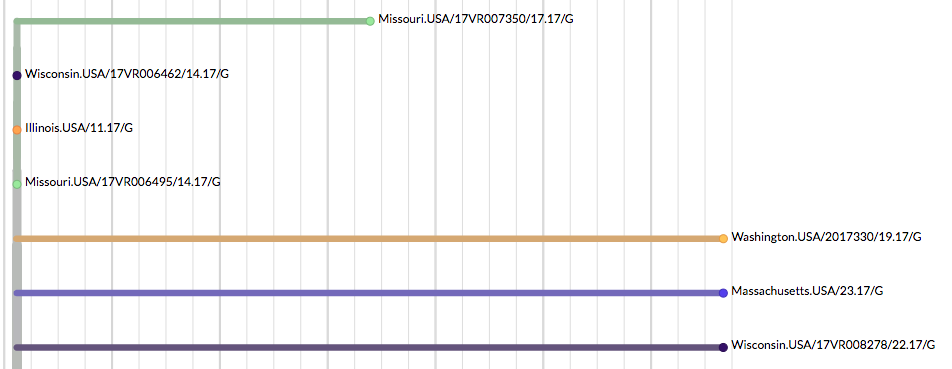

The code in this notebook will read in an auspice json produced by the Nextstrain pipeline (a v2 auspice json, although it is easy to adapt to v1 jsons). It will then iterate through the tree, and for each tip, assess whether that tip lies on an internal node, ie., has a branch length ~0. If it does, calculate the number of tips downstream from that internal node, minus the current tip, and store that value. Also calculate the downstream branch length. The output is a dataframe containing each tip, and its number of descendants. 

In the 2nd half of this notebook, this dataframe is used to look at 3 factors we believe might be important to mumps transmission: community status, vaccination status, and age. All of these factors are evaluted with a logistic regression run in R.

In [12]:
import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp

import pandas as pd
import numpy as np
import scipy as scipy
from scipy import stats

import json
import collections
from collections import Counter
from Bio import SeqIO
from Bio import Seq
import Bio.Phylo

import rpy2
%load_ext rpy2.ipython

# Functions from augur to read in nextstrain jsons and convert to trees

These functions are copied and pasted directly from nextstrain augur/base/io_util.py

In [13]:
# function to use the json module to read in a json file and store it as "data"                
def read_json(file_name):
    try:
        handle = open(file_name, 'r')
    except IOError:
        pass
    else:
        data = json.load(handle)
        handle.close()
    return data

In [14]:
# original code that Trevor gave me for parsing through tree jsons and returning descendents
def all_descendants(node):
    """Take node, ie. dict, and return a flattened list of all nodes descending from this node"""
    yield node
    
    # this will recursively return all internal nodes (nodes with children)
    if 'children' in node:
        for child in node['children']:
            for desc in all_descendants(child):
                yield desc

In [15]:
# Biopython's trees don't store links to node parents, so we need to build
# a map of each node to its parent.
# Code from the Bio.Phylo cookbook: http://biopython.org/wiki/Phylo_cookbook
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order='level'):
        for child in clade:
            parents[child] = clade
    return parents

In [16]:
def annotate_parents(tree):
    # Get all parent nodes by node.
    parents_by_node = all_parents(tree)

    # Next, annotate each node with its parent.
    for node in tree.find_clades():
        if node == tree.root:
            node.up = None
        else:
            node.up = parents_by_node[node]

    # Return the tree.
    return tree

In [17]:
def annotate_parents_for_tree(tree):
    """Annotate each node in the given tree with its parent.
    >>> import io
    >>> tree = Bio.Phylo.read(io.StringIO("(A, (B, C))"), "newick")
    >>> not any([hasattr(node, "parent") for node in tree.find_clades()])
    True
    >>> tree = annotate_parents_for_tree(tree)
    >>> tree.root.parent is None
    True
    >>> all([hasattr(node, "parent") for node in tree.find_clades()])
    True
    """
    tree.root.parent = None
    for node in tree.find_clades(order="level"):
        for child in node.clades:
            child.parent = node
    # Return the tree.
    return tree

In [18]:

def json_to_tree(json_dict, root=True):
    """Returns a Bio.Phylo tree corresponding to the given JSON dictionary exported
    by `tree_to_json`.

    Assigns links back to parent nodes for the root of the tree.

    >>> import json
    >>> json_fh = open("tests/data/json_tree_to_nexus/flu_h3n2_ha_3y_tree.json", "r")
    >>> json_dict = json.load(json_fh)
    >>> tree = json_to_tree(json_dict)
    >>> tree.name
    u'NODE_0002020'
    >>> len(tree.clades)
    2
    >>> tree.clades[0].name
    u'NODE_0001489'
    >>> hasattr(tree, "attr")
    True
    >>> "dTiter" in tree.attr
    True
    """
    node = Bio.Phylo.Newick.Clade()
    node.strain = json_dict["name"]

    if "children" in json_dict:
        # Recursively add children to the current node.
        node.clades = [json_to_tree(child, root=False) for child in json_dict["children"]]

    # Assign all non-children attributes.
    for attr, value in json_dict.items():
        if attr != "children":
            setattr(node, attr, value)

    """The 2 lines below needed to be altered to work with auspice v2 jsons. The original
    code for auspice v1 jsons is listed here: 
    node.numdate = node.attr.get("num_date")
    node.divergence = node.attr.get("div")"""
    
    node.numdate = node.node_attrs["num_date"]['value']
    node.divergence = node.node_attrs.get("div")
    
    if "translations" in node.node_attrs:
        node.translations = node.attr["translations"]

    if root:
        node = annotate_parents(node)

    return node

# Read in metadata, find proper parent node, and add branch lengths

In [37]:
def read_metadata(metadata_path):
    metadata = {}
    
    with open(metadata_path, "r") as infile: 
        for line in infile: 
            if "strain_name" not in line: # skip first line
                strain_name = line.split("\t")[0]
                ID = line.split("\t")[1]
                age = line.split("\t")[3]
                vaccination_status = line.split("\t")[4].lower()                    
                community_status = line.split("\t")[5]
                
                metadata[ID] = {}
                metadata[ID]['age'] = age
                metadata[ID]['vaccination_status'] = vaccination_status
                metadata[ID]['community_status'] = community_status
                
    return(metadata)

In [20]:
def return_marshallese_status(strain_name, metadata):
    
    ID = strain_name.split("/")[1]
    
    if "Washington" in strain_name: 
        community_status = metadata[ID]["community_status"]
    else: 
        community_status = "Not_Washington"
        
    return(community_status)

In [21]:
def return_vaccination_status(strain_name, metadata):
    
    ID = strain_name.split("/")[1]
    
    if "Washington" in strain_name: 
        vaccination_status = metadata[ID]["vaccination_status"]
    else: 
        vaccination_status = "Not_Washington"
        
    return(vaccination_status)

In [22]:
def return_age(strain_name, metadata):
    
    ID = strain_name.split("/")[1]
    
    if "Washington" in strain_name: 
        age = metadata[ID]["age"]
    else: 
        age = "Not_Washington"
        
    return(age)

In [23]:
def return_proper_parent_node(node):
    """given an internal node, traverse back up the tree to find a parental node with a 
    real branch length (basically, collapse the polytomy). This is necessary for most 
    tree software, including iqtree and treetime, which both normally atempt to resolve
    polytomies, resulting in a fully bifurcating tree with lots of very tiny branches"""
    
    #print(node, node.length)
    if abs(node.divergence - node.up.divergence) < cutoff: 
        
        #print("going up 1 node")
        if node.up !=None:
            parent_node = return_proper_parent_node(node.up)
        
        else:
            #print("root is proper parent")
            parent_node = node
    
    else: 
        #print("current node has proper length")
        parent_node = node
    
    return(parent_node)

In [24]:
def add_nodes(node):
    """Take node and add up branch lengths for total subtending tree from that node"""
    total_lengths = 0
    
    branch_length = node.divergence - node.up.divergence
    
    if node.is_terminal() == True: 
        total_lengths += branch_length
    
    else:
        total_lengths += branch_length
        for child in node.clades:
            
            total_lengths += add_nodes(child)
                            
    return(total_lengths)

In [25]:
def return_short_branches(tip):
    branch_length = tip.numdate - tip.up.numdate
    branch_length_days = branch_length * 365

    if branch_length_days <= 20:
        branch_length = "short"
    else: 
        branch_length = "long"
                
    return(branch_length_days)

In [26]:
def return_descendants_dict(tree, metadata, cutoff):
    
    WA = []
    output_dict = {}
    not_polytomies = []
    polytomies = []
    
    for i in tree.find_clades(): ## iterate over objects in tree            
        if i.is_terminal() == True:
                        
            community_status = return_marshallese_status(i.strain, metadata)
            vaccination_status = return_vaccination_status(i.strain, metadata)
            age = return_age(i.strain, metadata)
            
            # calculate branch length in time 
            time_branch_length = return_short_branches(i)
            
            # now do descendants/no descendants with divergences
            if abs(i.divergence - i.up.divergence < cutoff):
                if "Washington" in i.strain:
                    polytomies.append(i.strain)

                proper_parent = return_proper_parent_node(i.up)
                branch_length = add_nodes(proper_parent) - (i.divergence - i.up.divergence)
                children = len(proper_parent.get_terminals()) - 1

                output_dict[i.strain] = {}
                output_dict[i.strain]['branch_lengths'] = branch_length
                output_dict[i.strain]['number_children'] = children
                output_dict[i.strain]['community_status'] = community_status
                output_dict[i.strain]['vaccination_status'] = vaccination_status
                output_dict[i.strain]['age'] = age
                output_dict[i.strain]['time_branch_length'] = time_branch_length


            else:
                if "Washington" in i.strain:
                    not_polytomies.append(i.strain)
                    output_dict[i.strain] = {}
                    output_dict[i.strain]['branch_lengths'] = 0
                    output_dict[i.strain]['number_children'] = 0
                    output_dict[i.strain]['community_status'] = community_status
                    output_dict[i.strain]['vaccination_status'] = vaccination_status
                    output_dict[i.strain]['age'] = age
                    output_dict[i.strain]['time_branch_length'] = time_branch_length

    
    return(polytomies,not_polytomies,output_dict)

# Set paths, run it

In [27]:
"""set paths. This North American tree is distinct from thee tree on nextstrain.org/mumps/na because I retained all 
Washington sequences in it. Several Washington sequences are highly divergent, so they are dropped from Nextstrain,
but retained here"""
tree_path = "../auspice/mumps_na_all_WA.json"
metadata_path = "../sample-metadata-complete-2020-10-06.txt"

"""set cutoff value for defining a near 0 branch length; here I'm using 1e-16. The value 
that seems to be the minimum set for 0 branch lengths using treetime seems to be 6e-18,
so I have just it slightly higher."""
cutoff =  1e-16

# run
metadata = read_metadata(metadata_path)
combo_json = read_json(tree_path)
tree = combo_json['tree']
tree = json_to_tree(tree)
polytomies,not_polytomies,output_dict = return_descendants_dict(tree, metadata, cutoff)

## Convert to dataframe and subset down to Washington tips

In [28]:
df = pd.DataFrame.from_dict(output_dict, orient="index")
df.reset_index(inplace=True)
df.head()

,index,branch_lengths,number_children,community_status,vaccination_status,age,time_branch_length
0,Alabama.USA/11.17/G,0.005505,45,Not_Washington,Not_Washington,Not_Washington,23.170908
1,Alabama.USA/19.17/G,0.005505,45,Not_Washington,Not_Washington,Not_Washington,20.985626
2,Alabama.USA/7.17/G,0.005505,45,Not_Washington,Not_Washington,Not_Washington,0.549958
3,Arkansas.USA/12.17/G,0.002883,21,Not_Washington,Not_Washington,Not_Washington,34.496901
4,Arkansas.USA/38.16/G,0.007011,83,Not_Washington,Not_Washington,Not_Washington,11.630015


In [29]:
# subset dataframe to include only Washington tips and print the number of tips with descendants
WA_df = df[df['index'].str.contains("Washington")]
print(len(WA_df[WA_df['number_children'] > 0]), len(WA_df))

46 109


In [30]:
# classify whether time branch lengths is > or < the serial interval
WA_df['branch_length_category'] = np.where(WA_df['time_branch_length'] <= 20, 1,0)
WA_df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,index,branch_lengths,number_children,community_status,vaccination_status,age,time_branch_length,branch_length_category
170,Washington.USA/2017011/49.16/G,0.000000,0,Not_Marshallese,unknown,41,60.818597,0
171,Washington.USA/2017013/48.16/3/G,0.000197,1,Marshallese,up_to_date,11,18.659593,1
172,Washington.USA/2017018/49.16/3/G,0.000721,13,Not_Marshallese,unknown,28,0.000000,1
173,Washington.USA/2017023/50.16/G,0.000721,13,Marshallese,up_to_date,14,2.997947,1
174,Washington.USA/2017025/50.16/2/G,0.000000,0,Not_Marshallese,up_to_date,12,65.054496,0


In [20]:
WA_df.to_csv("WA_regression_dataframe.csv")

## Manually generate the dataframe 

this seems like a good thing to read: https://www.datacamp.com/community/tutorials/logistic-regression-R
and this https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/


I would like the following predictors, coded as the following: 

**1. community status**: Not Marshallese = 0, Marshallese = 1

**2. age**: continuous, leave as is 

**vaccination status:** 
for this, we need to break down into 2 categories: 
3. **vaccination unknown**: known vaccination status = 0, unknown status = 1
4. **up-to-date**: up-to-date vaccination status = 0, not up-to-date vaccination status = 1

The intercept will therefore reflect the odds of having descendants for a not marshallese person, of age 0, with a known vaccination status, who is vaccinated. This seems like a reasonable baseline. 

The dependent variable is has descendants. I will code this as 0 for no descendants and 1 for has descendants. 


I will use the `glm` function in R. This will fit a regression model to the input data. By specifying `binomial`, this will fit a logistic regression model, rather than a linear one. The significance values output are the result of a Wald test of significance. These are computed by comparing: 

for a model: `glm(y~x1+x2+x3, family="binomial")`:
* For coefficient of x1: `glm(y~x2+x3, family="binomial")` vs. `glm(y~x1+x2+x3, family="binomial")`
* For coefficient of x2: `glm(y~x1+x3, family="binomial")` vs. `glm(y~x1+x2+x3, family="binomial")`
* For coefficient of x3: `glm(y~x1+x2, family="binomial")` vs. `glm(y~x1+x2+x3, family="binomial")`

The order of tests does not matter here. 

This is a nice description of the difference between the results output by the `summary` command vs. the `anova`. For the anova comparison, you evaluate the model during sequential addition of predictors. Here, the order DOES matter. https://stats.stackexchange.com/questions/59879/logistic-regression-anova-chi-square-test-vs-significance-of-coefficients-ano

stepwise, this is what's occurring when you run `anova(model.final, test="Chisq")` 
1. `glm(y~1, family="binomial")` vs. `glm(y~x1, family="binomial")`
2. `glm(y~x1, family="binomial")` vs. `glm(y~x1+x2, family="binomial")`
3. `glm(y~x1+x2, family="binomial")` vs. `glm(y~x1+x2+x3, family="binomial")`

In [31]:
# convert age to numeric
WA_df['age'] = pd.to_numeric(WA_df['age'])

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
# normalize age 
min_age = min(WA_df['age'])
max_age = max(WA_df['age'])
WA_df['age_normalized'] = (WA_df['age'] - min_age)/(max_age - min_age)
WA_df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,index,branch_lengths,number_children,community_status,vaccination_status,age,time_branch_length,branch_length_category,age_normalized
170,Washington.USA/2017011/49.16/G,0.000000,0,Not_Marshallese,unknown,41,60.818597,0,0.571429
171,Washington.USA/2017013/48.16/3/G,0.000197,1,Marshallese,up_to_date,11,18.659593,1,0.142857
172,Washington.USA/2017018/49.16/3/G,0.000721,13,Not_Marshallese,unknown,28,0.000000,1,0.385714
173,Washington.USA/2017023/50.16/G,0.000721,13,Marshallese,up_to_date,14,2.997947,1,0.185714
174,Washington.USA/2017025/50.16/2/G,0.000000,0,Not_Marshallese,up_to_date,12,65.054496,0,0.157143


In [34]:
reg_df2 = WA_df.copy()
reg_df2['marshallese'] = np.where(reg_df2["community_status"] == "Not_Marshallese", 0, 1)
reg_df2['vaccination_status_unknown'] = np.where(reg_df2["vaccination_status"] == "unknown", 1, 0)
reg_df2['up_to_date'] = np.where(reg_df2["vaccination_status"] == "up_to_date", 0, 1)
reg_df2['has_descendants'] = np.where(reg_df2["number_children"] == 0, 0, 1)

# reg_df2.head()

In [35]:
# run a simple model with just marshallese status
%R -i reg_df2
%R model.marsh = glm(has_descendants~marshallese,data=reg_df2,family = binomial(link="logit"),na.action(na.omit))
%R print(summary(model.marsh))
%R print(exp(coef(model.marsh)))
%R print(anova(model.marsh, test="Chisq"))

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



Call:
glm(formula = has_descendants ~ marshallese, family = binomial(link = "logit"), 
    data = reg_df2, weights = na.action(na.omit))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.284  -0.792  -0.792   1.075   1.620  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  -0.9985     0.3126  -3.194  0.00140 **
marshallese   1.2454     0.4111   3.029  0.00245 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 148.44  on 108  degrees of freedom
Residual deviance: 138.74  on 107  degrees of freedom
AIC: 142.74

Number of Fisher Scoring iterations: 4



(Intercept) marshallese 
  0.3684211   3.4742857 


Analysis of Deviance Table

Model: binomial, link: logit

Response: has_descendants

Terms added sequentially (first to last)


            Df Deviance Resid. Df Resid. Dev Pr(>Chi)   
NULL                          108     148.44            
marshallese  1   9.7077       107     138.74 0.001835 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [36]:
# now run with all variables
%R -i reg_df2
%R model.has_descendants = glm(has_descendants~vaccination_status_unknown+up_to_date+age_normalized+marshallese,data=reg_df2,family = binomial(link="logit"),na.action(na.omit))
%R print(summary(model.has_descendants))  # print the summary
%R print(exp(coef(model.has_descendants)))  # exponentiate the coefficients
%R print(exp(confint(model.has_descendants)))   # exponentiate the confidence intervals
%R print(anova(model.has_descendants, test="Chisq"))  # run a chi square?


Call:
glm(formula = has_descendants ~ vaccination_status_unknown + 
    up_to_date + age_normalized + marshallese, family = binomial(link = "logit"), 
    data = reg_df2, weights = na.action(na.omit))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4380  -0.8888  -0.6877   1.0379   1.8491  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)   
(Intercept)                 -0.5364     0.5003  -1.072  0.28362   
vaccination_status_unknown   0.7940     0.8043   0.987  0.32358   
up_to_date                  -0.7733     0.6863  -1.127  0.25980   
age_normalized              -1.2000     1.4426  -0.832  0.40549   
marshallese                  1.1652     0.4340   2.685  0.00725 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 148.44  on 108  degrees of freedom
Residual deviance: 136.32  on 104  degrees of freedom
AIC: 146.32

Number of Fisher Sco

               (Intercept) vaccination_status_unknown 
                 0.5848337                  2.2121590 
                up_to_date             age_normalized 
                 0.4614673                  0.3011947 
               marshallese 
                 3.2067213 


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Waiting for profiling to be done...

  warnings.warn(x, RRuntimeWarning)


                                2.5 %    97.5 %
(Intercept)                0.21247739  1.538262
vaccination_status_unknown 0.48659788 11.887176
up_to_date                 0.10880748  1.698234
age_normalized             0.01575397  4.699753
marshallese                1.39124061  7.691339


Analysis of Deviance Table

Model: binomial, link: logit

Response: has_descendants

Terms added sequentially (first to last)


                           Df Deviance Resid. Df Resid. Dev Pr(>Chi)   
NULL                                         108     148.44            
vaccination_status_unknown  1   0.4135       107     148.03 0.520200   
up_to_date                  1   1.1693       106     146.86 0.279535   
age_normalized              1   2.9862       105     143.88 0.083975 . 
marshallese                 1   7.5520       104     136.32 0.005994 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Interpretation 

An odds ratio of 3.2 for Marshallese means that the odds of having descendants and being Marshallese is 3.2. So Marshallese people are 320% more likely to have descendants than non-Marshallese, holding all other variables constant (assuming age 0 and known, vaccinated vaccination status). 

An odds ratio of 0.46 for up-to-date means that the odds of having descendants and being not up-to-date is 0.46, holding all other variables constant (being not Marshallese, having age 0, and having a known vaccination status). This is not statistically significant. 

An odds ratio of 2.21 for vaccination unknown means that the odds of having descendants and having an unknown vaccination status is 2.2, holding all other variables constant (being vaccinated, age 0, not Marshallese). However, this is not significant. 

Finally, we get an odds ratio of 0.30 for normalized age. This is also not statistically significant. 

Significance testing by the Wald statistic is: b/se(b), where b is the coefficient and se is the standard error. 

For the ANOVA, I tried adding Marshallese as a predictor at the very beginning or very end, and it continues to be significant. 